## CODE

### Load the data

In [265]:
import pandas as pd
df = pd.read_csv('diabetic_data.csv')
df

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,AfricanAmerican,Male,[70-80),?,1,3,7,3,MC,?,51,0,16,0,0,0,250.13,291,458,9,None,>8,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,>30
101762,443847782,74694222,AfricanAmerican,Female,[80-90),?,1,4,5,5,MC,?,33,3,18,0,0,1,560,276,787,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,NO
101763,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,MC,?,53,0,9,1,0,0,38,590,296,13,None,None,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,NO
101764,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,MC,Surgery-General,45,2,21,0,0,1,996,285,998,9,None,None,No,No,No,No,No,No,Steady,No,No,Steady,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO


### Cleaning the data

#### So, we have 49 features and 101766 rows of Data.

In [266]:
print('Shape of the features data -', df.iloc[:,:-1].shape) 
print('Shape of the label -', df['readmitted'].shape)

Shape of the features data - (101766, 49)
Shape of the label - (101766,)


In [267]:
num_cols = df._get_numeric_data().columns

In [268]:
l = list(set(df.columns) - set(num_cols))
print(len(l), len(num_cols))

37 13


In [269]:
df2 = df[l]

In [270]:
del df2['readmitted']
del df2['weight']

In [271]:
df2

,diag_2,change,rosiglitazone,examide,diag_3,glyburide-metformin,glimepiride-pioglitazone,diag_1,tolbutamide,age,pioglitazone,gender,glipizide,insulin,repaglinide,citoglipton,miglitol,glipizide-metformin,acetohexamide,metformin,acarbose,metformin-rosiglitazone,metformin-pioglitazone,chlorpropamide,max_glu_serum,troglitazone,nateglinide,A1Cresult,medical_specialty,diabetesMed,race,glyburide,tolazamide,payer_code,glimepiride
0,?,No,No,No,?,No,No,250.83,No,[0-10),No,Female,No,No,No,No,No,No,No,No,No,No,No,No,None,No,No,None,Pediatrics-Endocrinology,No,Caucasian,No,No,?,No
1,250.01,Ch,No,No,255,No,No,276,No,[10-20),No,Female,No,Up,No,No,No,No,No,No,No,No,No,No,None,No,No,None,?,Yes,Caucasian,No,No,?,No
2,250,No,No,No,V27,No,No,648,No,[20-30),No,Female,Steady,No,No,No,No,No,No,No,No,No,No,No,None,No,No,None,?,Yes,AfricanAmerican,No,No,?,No
3,250.43,Ch,No,No,403,No,No,8,No,[30-40),No,Male,No,Up,No,No,No,No,No,No,No,No,No,No,None,No,No,None,?,Yes,Caucasian,No,No,?,No
4,157,Ch,No,No,250,No,No,197,No,[40-50),No,Male,Steady,Steady,No,No,No,No,No,No,No,No,No,No,None,No,No,None,?,Yes,Caucasian,No,No,?,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,291,Ch,No,No,458,No,No,250.13,No,[70-80),No,Male,No,Down,No,No,No,No,No,Steady,No,No,No,No,None,No,No,>8,?,Yes,AfricanAmerican,No,No,MC,No
101762,276,No,No,No,787,No,No,560,No,[80-90),No,Female,No,Steady,No,No,No,No,No,No,No,No,No,No,None,No,No,None,?,Yes,AfricanAmerican,No,No,MC,No
101763,590,Ch,No,No,296,No,No,38,No,[70-80),No,Male,No,Down,No,No,No,No,No,Steady,No,No,No,No,None,No,No,None,?,Yes,Caucasian,No,No,MC,No
101764,285,Ch,No,No,998,No,No,996,No,[80-90),Steady,Female,Steady,Up,No,No,No,No,No,No,No,No,No,No,None,No,No,None,Surgery-General,Yes,Caucasian,No,No,MC,No


#### Categorical to numerical

In [272]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
temp = lb_make.fit_transform(df2['rosiglitazone'])
df4 = pd.DataFrame(temp)
df4.columns = ['rosiglitazone']

for x in range((df2.shape[1])-1): 
    temp = lb_make.fit_transform(df2[df2.columns[x+1]])
    df4[df2.columns[x+1]] = pd.DataFrame(temp)

In [273]:
df4

,rosiglitazone,change,examide,diag_3,glyburide-metformin,glimepiride-pioglitazone,diag_1,tolbutamide,age,pioglitazone,gender,glipizide,insulin,repaglinide,citoglipton,miglitol,glipizide-metformin,acetohexamide,metformin,acarbose,metformin-rosiglitazone,metformin-pioglitazone,chlorpropamide,max_glu_serum,troglitazone,nateglinide,A1Cresult,medical_specialty,diabetesMed,race,glyburide,tolazamide,payer_code,glimepiride
0,1,1,0,670,1,0,124,0,0,1,0,1,1,1,0,1,0,0,1,1,0,0,1,2,0,1,2,38,0,3,1,0,0,1
1,1,0,0,121,1,0,143,0,1,1,0,1,3,1,0,1,0,0,1,1,0,0,1,2,0,1,2,0,1,3,1,0,0,1
2,1,1,0,767,1,0,454,0,2,1,0,2,1,1,0,1,0,0,1,1,0,0,1,2,0,1,2,0,1,1,1,0,0,1
3,1,0,0,248,1,0,554,0,3,1,1,1,3,1,0,1,0,0,1,1,0,0,1,2,0,1,2,0,1,3,1,0,0,1
4,1,0,0,86,1,0,54,0,4,1,1,2,2,1,0,1,0,0,1,1,0,0,1,2,0,1,2,0,1,3,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,1,0,0,295,1,0,102,0,7,1,1,1,0,1,0,1,0,0,2,1,0,0,1,2,0,1,1,0,1,1,1,0,8,1
101762,1,1,0,536,1,0,381,0,8,1,0,1,2,1,0,1,0,0,1,1,0,0,1,2,0,1,2,0,1,1,1,0,8,1
101763,1,0,0,159,1,0,236,0,7,1,1,1,0,1,0,1,0,0,2,1,0,0,1,2,0,1,2,0,1,3,1,0,8,1
101764,1,0,0,668,1,0,693,0,8,2,0,2,3,1,0,1,0,0,1,1,0,0,1,2,0,1,2,63,1,3,1,0,8,1


In [274]:
df5 = df[num_cols].join(df4)

In [275]:
df5

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,rosiglitazone,change,examide,diag_3,glyburide-metformin,glimepiride-pioglitazone,diag_1,tolbutamide,age,pioglitazone,gender,glipizide,insulin,repaglinide,citoglipton,miglitol,glipizide-metformin,acetohexamide,metformin,acarbose,metformin-rosiglitazone,metformin-pioglitazone,chlorpropamide,max_glu_serum,troglitazone,nateglinide,A1Cresult,medical_specialty,diabetesMed,race,glyburide,tolazamide,payer_code,glimepiride
0,2278392,8222157,6,25,1,1,41,0,1,0,0,0,1,1,1,0,670,1,0,124,0,0,1,0,1,1,1,0,1,0,0,1,1,0,0,1,2,0,1,2,38,0,3,1,0,0,1
1,149190,55629189,1,1,7,3,59,0,18,0,0,0,9,1,0,0,121,1,0,143,0,1,1,0,1,3,1,0,1,0,0,1,1,0,0,1,2,0,1,2,0,1,3,1,0,0,1
2,64410,86047875,1,1,7,2,11,5,13,2,0,1,6,1,1,0,767,1,0,454,0,2,1,0,2,1,1,0,1,0,0,1,1,0,0,1,2,0,1,2,0,1,1,1,0,0,1
3,500364,82442376,1,1,7,2,44,1,16,0,0,0,7,1,0,0,248,1,0,554,0,3,1,1,1,3,1,0,1,0,0,1,1,0,0,1,2,0,1,2,0,1,3,1,0,0,1
4,16680,42519267,1,1,7,1,51,0,8,0,0,0,5,1,0,0,86,1,0,54,0,4,1,1,2,2,1,0,1,0,0,1,1,0,0,1,2,0,1,2,0,1,3,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,1,3,7,3,51,0,16,0,0,0,9,1,0,0,295,1,0,102,0,7,1,1,1,0,1,0,1,0,0,2,1,0,0,1,2,0,1,1,0,1,1,1,0,8,1
101762,443847782,74694222,1,4,5,5,33,3,18,0,0,1,9,1,1,0,536,1,0,381,0,8,1,0,1,2,1,0,1,0,0,1,1,0,0,1,2,0,1,2,0,1,1,1,0,8,1
101763,443854148,41088789,1,1,7,1,53,0,9,1,0,0,13,1,0,0,159,1,0,236,0,7,1,1,1,0,1,0,1,0,0,2,1,0,0,1,2,0,1,2,0,1,3,1,0,8,1
101764,443857166,31693671,2,3,7,10,45,2,21,0,0,1,9,1,0,0,668,1,0,693,0,8,2,0,2,3,1,0,1,0,0,1,1,0,0,1,2,0,1,2,63,1,3,1,0,8,1


#### Co-relation matrix

In [276]:
co_matrix = df5.corr()
co_matrix.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,rosiglitazone,change,examide,diag_3,glyburide-metformin,glimepiride-pioglitazone,diag_1,tolbutamide,age,pioglitazone,gender,glipizide,insulin,repaglinide,citoglipton,miglitol,glipizide-metformin,acetohexamide,metformin,acarbose,metformin-rosiglitazone,metformin-pioglitazone,chlorpropamide,max_glu_serum,troglitazone,nateglinide,A1Cresult,medical_specialty,diabetesMed,race,glyburide,tolazamide,payer_code,glimepiride
encounter_id,1.00,0.51,-0.16,-0.13,-0.11,-0.06,-0.03,-0.01,0.08,0.10,0.08,0.03,0.27,-0.05,-0.10,nan,0.02,0.03,0.00,0.01,-0.01,0.07,0.04,0.01,-0.01,0.05,0.02,nan,-0.00,0.00,-0.00,0.03,-0.00,0.01,0.01,-0.02,0.03,-0.01,0.02,0.02,-0.17,0.05,0.08,-0.06,-0.02,0.44,0.03
patient_nbr,0.51,1.00,-0.01,-0.14,-0.03,-0.02,0.02,-0.02,0.02,0.10,0.06,0.01,0.23,-0.01,-0.05,nan,0.01,0.03,-0.00,0.02,-0.00,0.07,0.04,0.01,0.00,-0.00,0.05,nan,0.01,-0.00,-0.00,0.01,0.01,0.01,-0.00,-0.01,0.01,-0.00,0.02,0.02,-0.14,0.02,0.15,-0.04,-0.01,0.23,0.02
admission_type_id,-0.16,-0.01,1.00,0.08,0.11,-0.01,-0.14,0.13,0.08,0.03,-0.02,-0.04,-0.12,0.02,-0.01,nan,-0.01,-0.00,-0.00,0.04,0.00,-0.01,0.01,0.01,0.01,-0.01,-0.00,nan,0.00,-0.00,-0.00,0.01,0.00,-0.00,0.00,0.01,-0.10,0.00,-0.01,0.01,0.19,-0.00,0.10,0.00,0.01,-0.14,-0.00
discharge_disposition_id,-0.13,-0.14,0.08,1.00,0.02,0.16,0.02,0.02,0.11,-0.01,-0.02,0.02,0.05,-0.01,0.01,nan,0.01,-0.00,-0.00,0.03,0.00,0.11,-0.01,-0.02,-0.01,-0.02,-0.00,nan,0.00,0.00,0.01,-0.01,0.01,-0.00,-0.00,0.02,-0.02,0.01,-0.01,0.01,-0.02,-0.03,0.01,0.04,0.01,-0.12,-0.02
admission_source_id,-0.11,-0.03,0.11,0.02,1.00,-0.01,0.05,-0.14,-0.05,0.03,0.06,0.04,0.07,-0.01,-0.00,nan,-0.01,-0.02,0.00,-0.02,0.01,0.04,-0.01,-0.00,0.01,-0.01,-0.00,nan,0.00,-0.00,0.00,-0.03,-0.00,-0.00,-0.00,-0.00,-0.09,0.00,-0.02,-0.00,-0.15,0.00,0.03,0.00,0.00,-0.10,-0.02
time_in_hospital,-0.06,-0.02,-0.01,0.16,-0.01,1.00,0.32,0.19,0.47,-0.01,-0.01,0.07,0.22,0.01,-0.11,nan,0.03,-0.00,-0.00,-0.03,0.00,0.11,0.01,-0.03,0.01,0.05,0.03,nan,0.00,-0.00,0.01,-0.00,0.01,-0.00,0.00,0.00,-0.04,0.00,0.00,-0.03,0.03,0.06,-0.02,0.02,-0.00,-0.04,0.01
num_lab_procedures,-0.03,0.02,-0.14,0.02,0.05,0.32,1.00,0.06,0.27,-0.01,-0.00,0.04,0.15,-0.01,-0.06,nan,-0.01,-0.01,-0.00,-0.07,0.00,0.02,-0.01,-0.00,0.01,0.04,0.01,nan,-0.00,-0.01,0.00,-0.04,-0.00,0.00,-0.00,-0.00,0.01,0.00,-0.01,-0.12,-0.07,0.03,-0.02,-0.01,-0.00,-0.05,-0.00
num_procedures,-0.01,-0.02,0.13,0.02,-0.14,0.19,0.06,1.00,0.39,-0.02,-0.04,-0.07,0.07,0.01,-0.00,nan,0.00,-0.00,-0.00,-0.03,-0.00,-0.03,0.01,0.06,0.00,0.01,0.00,nan,-0.00,-0.01,0.00,-0.04,-0.00,0.00,-0.00,0.01,0.02,-0.00,-0.00,0.00,0.08,-0.01,0.03,0.00,0.00,-0.05,0.01
num_medications,0.08,0.02,0.08,0.11,-0.05,0.47,0.27,0.39,1.00,0.05,0.01,0.06,0.26,0.05,-0.25,nan,0.01,0.01,-0.00,0.01,0.00,0.04,0.06,-0.02,0.05,0.08,0.02,nan,0.00,0.00,0.01,0.06,0.02,0.01,0.00,0.00,-0.03,0.00,0.02,-0.01,0.04,0.19,0.03,0.03,-0.00,0.00,0.04
number_outpatient,0.10,0.10,0.03,-0.01,0.03,-0.01,-0.01,-0.02,0.05,1.00,0.09,0.11,0.09,-0.00,-0.02,nan,0.02,-0.01,-0.00,-0.01,-0.00,0.02,0.01,-0.01,0.00,0.01,0.00,nan,-0.00,0.00,-0.00,-0.01,0.01,-0.00,-0.00,-0.00,-0.01,-0.00,0.00,0.00,-0.05,0.02,0.05,-0.01,-0.01,0.06,-0.01


In [277]:
del df5['examide']
del df5['citoglipton']
del df5['glimepiride-pioglitazone']

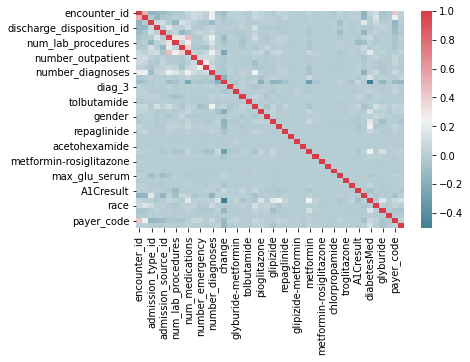

In [278]:
co_matrix = df5.corr()
import seaborn as sns
sns.heatmap(co_matrix, cmap=sns.diverging_palette(220, 10, as_cmap=True))

### Scale the data 0-1

In [279]:
def rescaleVector(x):
    min = x.min()
    max = x.max()
    return pd.Series([(element - min)/(max - min) for element in x])

x_rescale = rescaleVector(df5['rosiglitazone'])
df6 = pd.DataFrame(x_rescale)

for x in range((df5.shape[1]) - 1): 
    x_rescale = rescaleVector(df5[df5.columns[x+1]])
    df6[df5.columns[x+1]] = pd.DataFrame(x_rescale)

In [280]:
df['readmitted'] = df['readmitted'].apply(lambda x: '0' if x == 'NO' else '1')
df['readmitted'] = df['readmitted'].astype(float)

### Bseline model

In [281]:
sum(df['readmitted']==0)/len(df['readmitted'])

0.5391191557101586

### Logistic regression with k cross validation

In [282]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore') 

X = df6
Y = df['readmitted']

def k(k):
    kf = model_selection.KFold(n_splits=k, shuffle=True)
    model = LogisticRegression(n_jobs=-1)
    result = cross_val_score(model, X, Y, cv = kf, n_jobs = -1)
    print("Avg accuracy: {:.4f}".format(result.mean()))

lis = [3,5,10]
for x in range(len(lis)):
    k(lis[x])

Avg accuracy: 0.6176
Avg accuracy: 0.6177
Avg accuracy: 0.6174


### ROC

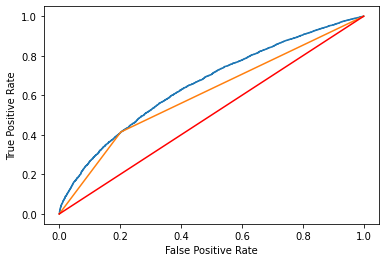

In [283]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np

x = x = np.linspace(0,1,100)
train, test, train_t, test_t = train_test_split(X, Y, train_size=0.9)
model = LogisticRegression(n_jobs=-1)
model.fit(train, train_t)

plt.plot(*roc_curve(test_t, model.predict_proba(test)[:,1])[:2])
plt.plot(*roc_curve(test_t, model.predict(test))[:2])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.plot(x, x, '-r')
plt.show()

In [284]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(test_t, model.predict_proba(test)[:,1])
print(auc)

0.656110394157508


### PR CURVE

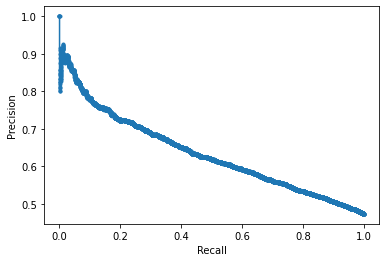

In [285]:
from sklearn.metrics import precision_recall_curve
lr_precision, lr_recall = precision_recall_curve(test_t, model.predict_proba(test)[:,1])[:2]
plt.plot(lr_recall, lr_precision, marker='.',)

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.show()